# Analizando el dataset de Audio

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import random
import soundfile as sf
import seaborn as sns
import pandas as pd
from IPython.display import Audio, display

In [2]:
# Ruta de la carpeta del dataset
audio_folder = 'Audio'

### Análisis inicial del dataset

In [3]:
def plot_subfolder_statistics(audio_folder):
    subfolders = [f.path for f in os.scandir(audio_folder) if f.is_dir()]
    durations = []
    amplitudes = []
    subfolder_names = []

    for subfolder in subfolders:
        audio_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.wav')]
        subfolder_durations = []
        subfolder_amplitudes = []

        for file_path in audio_files:
            y, sr = librosa.load(file_path)
            duration = librosa.get_duration(y=y, sr=sr)
            amplitude = np.mean(np.abs(y))
            
            subfolder_durations.append(duration)
            subfolder_amplitudes.append(amplitude)
        
        durations.extend(subfolder_durations)
        amplitudes.extend(subfolder_amplitudes)
        subfolder_names.extend([os.path.basename(subfolder)] * len(subfolder_durations))

    data = {'Subfolder': subfolder_names, 'Duration': durations, 'Amplitude': amplitudes}
    df = pd.DataFrame(data)

    # Gráfico del número de archivos por subcarpeta
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x='Subfolder')
    plt.title('Número de archivos por subcarpeta')
    plt.ylabel('Cantidad de Archivos')
    plt.xlabel('Clase')
    plt.xticks(rotation=45)
    plt.show()

    # Gráficos de violín para duración promedio y amplitud promedio
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    sns.violinplot(data=df, x='Subfolder', y='Duration')
    plt.title('Duración de los audios por subcarpeta')
    plt.ylabel('Duración (s)')
    plt.xlabel('Clase')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x='Subfolder', y='Amplitude')
    plt.title('Amplitud de los audios por subcarpeta')
    plt.ylabel('Amplitud Promedio')
    plt.xlabel('Clase')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


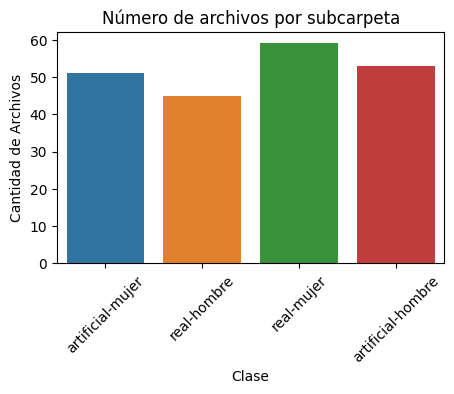

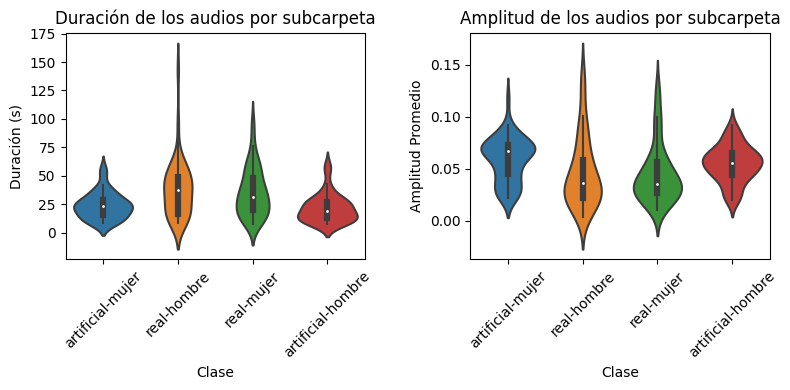

In [4]:
plot_subfolder_statistics(audio_folder)

### Análisis de los audios por clase

In [5]:
def visualize_audio(y, sr, mfcc, file_path):
    # Visualización de la señal de audio
    plt.figure(figsize=(9.2, 2))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Señal de Audio de {os.path.basename(file_path)}')
    plt.ylabel('Amplitude')  # Etiqueta para el eje Y de la señal de audio
    plt.show()
    
    # Visualización de los MFCC
    plt.figure(figsize=(10, 2.5))
    librosa.display.specshow(mfcc, x_axis='time', y_axis='linear') #y_axis='log'
    plt.colorbar()
    plt.ylabel('MFCC Coefficients (Hz)')  # Etiqueta para el eje Y de los MFCC
    plt.title(f'MFCC de {os.path.basename(file_path)}')
    plt.tight_layout()
    plt.show()
        
    # Reproducción del audio
    display(Audio(y, rate=sr))

In [6]:
def select_random_audio_from_each_subfolder(audio_folder):
    selected_files = []
    subfolders = [f.path for f in os.scandir(audio_folder) if f.is_dir()]
    for subfolder in subfolders:
        audio_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith('.wav')]
        if audio_files:
            selected_file = random.choice(audio_files)
            selected_files.append(selected_file)
    return selected_files

In [7]:
def process_and_visualize_audio(files):
    for file_path in files:
        y, sr = librosa.load(file_path)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        
        # Visualización
        visualize_audio(y, sr, mfcc, file_path)
        
        # Encuentra los 5 segundos centrales del audio
        if len(y) > 5 * sr:  # Más largo que 5 segundos
            start_sample = (len(y) // 2) - (2.5 * sr)
            end_sample = (len(y) // 2) + (2.5 * sr)
            y_trimmed = y[int(start_sample):int(end_sample)]
        else:
            y_trimmed = y  # Si el audio es más corto que 5 segundos, usa el audio completo
        mfcc_trimmed = librosa.feature.mfcc(y=y_trimmed, sr=sr)
        
        # Visualización
        visualize_audio(y_trimmed, sr, mfcc_trimmed, file_path)

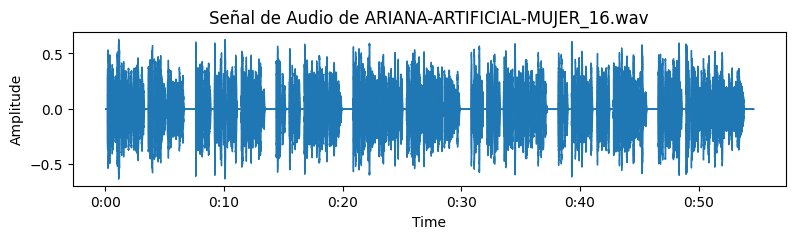

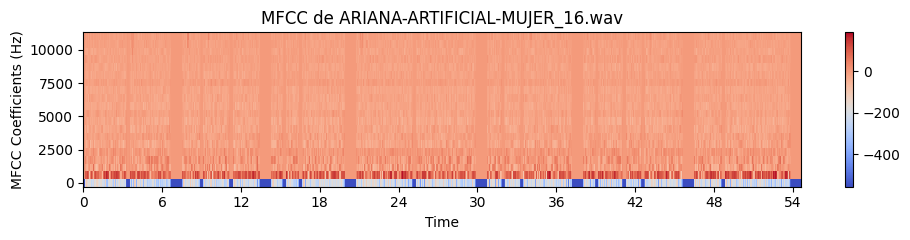

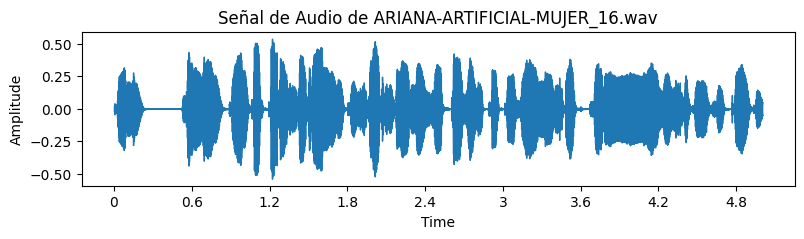

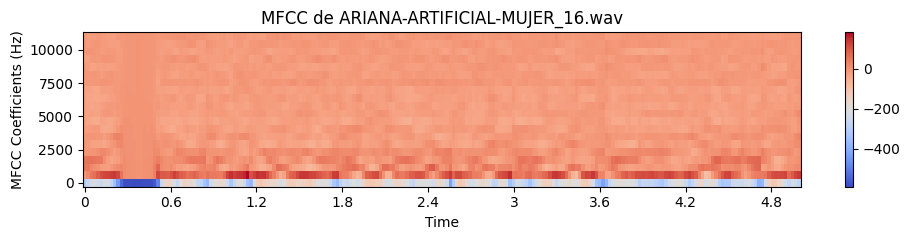

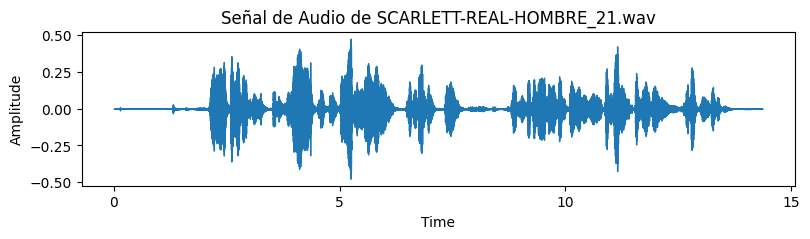

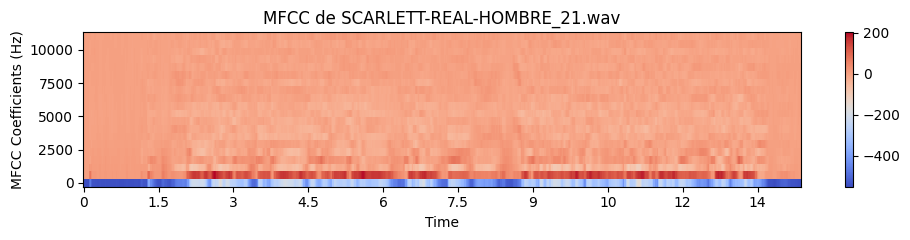

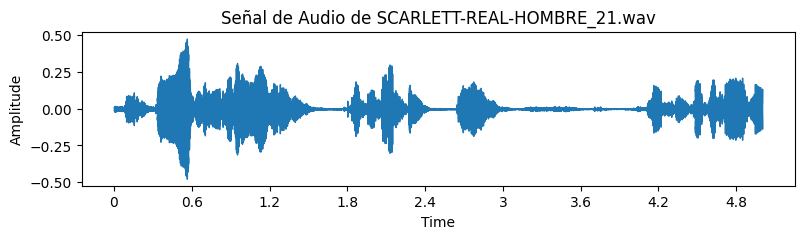

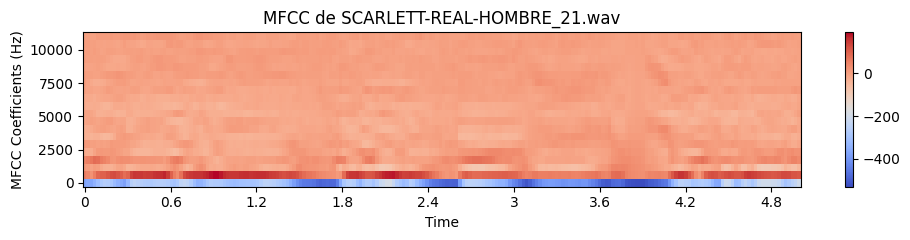

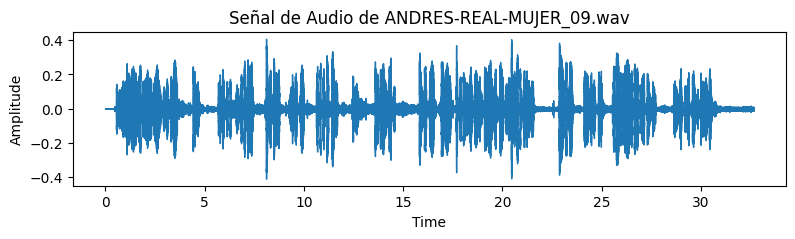

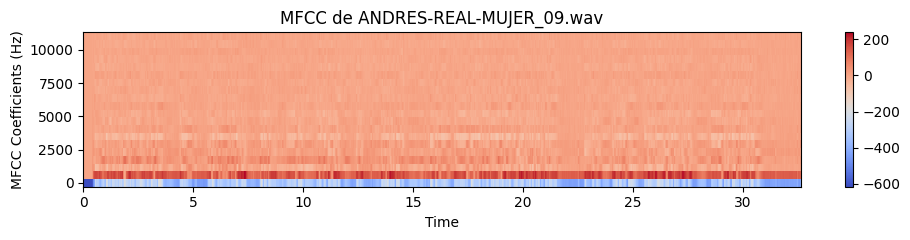

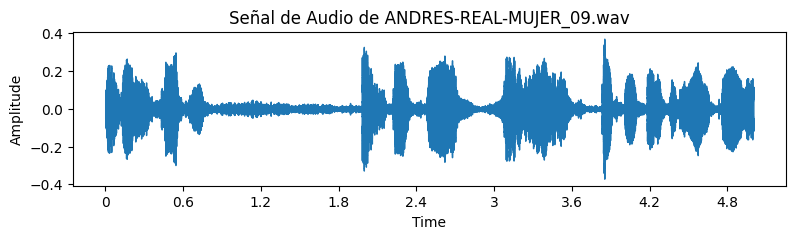

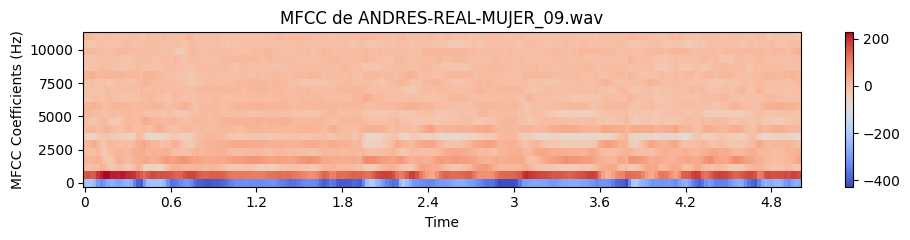

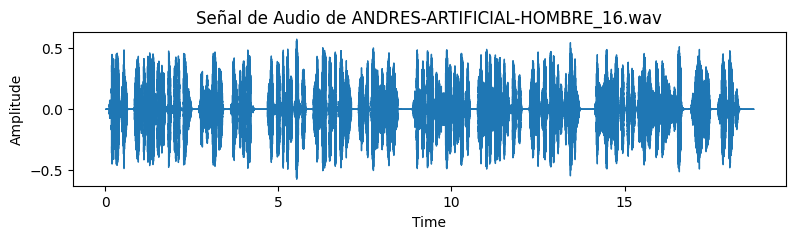

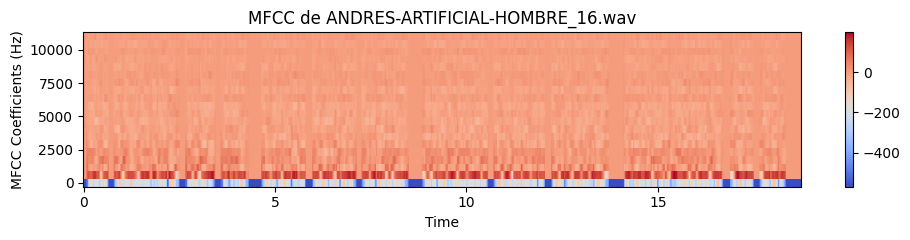

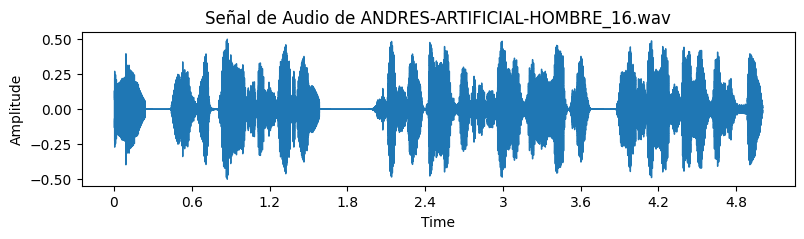

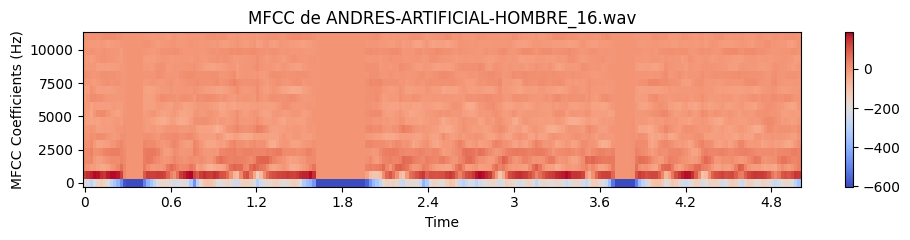

In [8]:
# Selecciona un archivo aleatoriamente de cada subcarpeta y procesa los archivos de audio originales
selected_files = select_random_audio_from_each_subfolder(audio_folder)
process_and_visualize_audio(selected_files)

### Generación del dataframe y dataset de imágenes MFCC

Se extraen los promedios de los coeficientes cepstrales MFCC. Bajo esta representación temporal-frecuencia no se recomienda hacer selección de características, puesto que las features no son 'pareadas' en el dominio del tiempo entre las muestras.

In [9]:
def extract_keywords_from_filename(filename):
    keywords = ['hombre', 'mujer', 'artificial', 'real']
    filename_lower = filename.lower()  # Convierte el nombre del archivo a minúsculas
    found_keywords = {keyword: keyword for keyword in keywords if keyword in filename_lower}
    gender = found_keywords.get('hombre', None) or found_keywords.get('mujer', None)
    subclass = found_keywords.get('artificial', None) or found_keywords.get('real', None)
    return gender, subclass

In [10]:
def create_mfcc_images(y, sr, output_folder, class_label, file_name):
    # Genera los MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    # Configura el tamaño de la figura para guardar la imagen
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, sr=sr)
    plt.axis('off')  
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  

    # Guarda la figura en la subcarpeta correspondiente
    plt.savefig(os.path.join(output_folder, class_label + "MFCC", file_name + '.png'), bbox_inches='tight', pad_inches=0)
    plt.close()  # Cierra la figura para liberar memoria

In [11]:
def extract_mfcc_and_create_dataframe(audio_folder, output_base_folder):
    rows = []
    for root, dirs, files in os.walk(audio_folder):
        class_label = os.path.basename(root)
        for file in files:
            if file.endswith('.wav'):
                gender, subclass = extract_keywords_from_filename(file)
                file_path = os.path.join(root, file)
                y, sr = librosa.load(file_path, sr=None)
                # Asegúrate de que los índices sean enteros
                if len(y) > 5 * sr:
                    mid = len(y) // 2
                    start = int(mid - 2.5 * sr)
                    end = int(mid + 2.5 * sr)
                    y_trimmed = y[start:end]
                else:
                    y_trimmed = y
                mfcc = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
                mfccs_processed = np.mean(mfcc.T, axis=0)
                row = mfccs_processed.tolist() + [subclass, gender, class_label, file]
                rows.append(row)
                
                # Asegurarse de que la subcarpeta exista
                mfcc_folder = os.path.join(output_base_folder, class_label + "MFCC")
                if not os.path.exists(mfcc_folder):
                    os.makedirs(mfcc_folder)
                
                # Guarda la imagen de los MFCC
                create_mfcc_images(y_trimmed, sr, output_base_folder, class_label, os.path.splitext(file)[0])
                
    # Crear DataFrame
    column_labels = [f'MFCC_{i+1}' for i in range(13)] + ['class', 'gender', 'subclass', 'file']
    df = pd.DataFrame(rows, columns=column_labels)
    return df                

In [12]:
def save_dataframe_to_csv(df, file_name):
    # Guarda el DataFrame en un archivo CSV
    df.to_csv(file_name, index=False)
    print(f"DataFrame guardado exitosamente en '{file_name}'")

In [13]:
# nombre del dataframe de salida
file_name = "Audio/dataframe_audio_mfcc.csv"
# nombre de la carpeta para las imágenes
output_base_folder = 'Audio/MFCC'  

df = extract_mfcc_and_create_dataframe(audio_folder, output_base_folder)

# Llama a la función para guardar el DataFrame en un archivo CSV
save_dataframe_to_csv(df, file_name)

print(df.head())  # Mostrar las primeras filas del dataframe

DataFrame guardado exitosamente en 'Audio/dataframe_audio_mfcc.csv'
       MFCC_1      MFCC_2     MFCC_3     MFCC_4    MFCC_5     MFCC_6  \
0 -336.230804   91.303986   3.593357   3.211611  9.330145 -16.995619   
1 -335.260559  109.178566 -13.736086  25.206469 -5.589324   3.462494   
2 -323.477203  105.812515   5.171504  22.666744 -7.003358  20.433336   
3 -300.296631   99.198280  -4.236248  30.183870 -6.294889  24.496006   
4 -378.743073   87.567192   3.122032  26.175056  4.004899  18.946613   

      MFCC_7     MFCC_8     MFCC_9    MFCC_10    MFCC_11    MFCC_12  \
0 -11.893817 -10.324425 -15.894041 -10.551913  -8.927979 -10.745314   
1 -18.705063  -7.152488  -8.890899 -23.390997  -8.075380   0.508852   
2 -16.361042  13.326266  -3.989311 -10.615167  -8.856272  -8.299376   
3 -22.706938   3.908201 -11.609993  -8.935787 -19.961813  -8.858082   
4 -16.916704   7.638995  -3.115278  -5.583471   1.080616  -5.865233   

     MFCC_13       class gender          subclass  \
0 -13.523055  artif

### Carga de dataset y análisis de las etiquetas

In [14]:
csv_file_path = 'Audio/dataframe_audio_mfcc.csv'

In [15]:
def load_and_show_distribution(csv_file_path):
    # Cargamos el archivo CSV en un DataFrame de pandas
    df = pd.read_csv(csv_file_path)
    
    # Ordenamos el DataFrame alfabéticamente por la columna "subclass"
    df = df.sort_values(by='subclass', ascending=True)
    
    # Configuramos el estilo de los gráficos
    sns.set(style="whitegrid")
    
    # Mostramos la distribución de la columna "class" con seaborn
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x='class', order = df['class'].value_counts().index)
    plt.title('Distribución de la Clase')
    plt.xticks(rotation=45)
    plt.show()
    
    # Mostramos la distribución de la columna "gender" con seaborn
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x='gender', order = df['gender'].value_counts().index)
    plt.title('Distribución del Género')
    plt.show()
    
    # Mostramos la distribución de la columna "subclass" con seaborn
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x='subclass', order = df['subclass'].value_counts().index)
    plt.title('Distribución de la Subclase')
    plt.show()

In [16]:
def load_and_show_distribution(csv_file_path):
    # Cargamos el archivo CSV en un DataFrame de pandas
    df = pd.read_csv(csv_file_path)
    
    # Ordenamos el DataFrame alfabéticamente por la columna "subclass"
    df = df.sort_values(by='subclass', ascending=True)
    
    # Configuramos el estilo de los gráficos
    sns.set(style="whitegrid")
    
    # Creamos una figura con subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    
    # Gráfico de distribución de "class"
    palette = {'real': 'lightgrey', 'artificial': 'dimgray'}
    sns.countplot(ax=axes[0], data=df, x='class', palette=palette)
    axes[0].set_title('Distribución de la Clase')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Gráfico de distribución de "gender" con colores personalizados
    palette = {'hombre': 'steelblue', 'mujer': 'hotpink'}  
    sns.countplot(ax=axes[1], data=df, x='gender', palette=palette)
    axes[1].set_title('Distribución del Género')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Gráfico de distribución de "subclass"
    palette = {'real-mujer': 'lightpink', 'artificial-mujer': 'deeppink', 
               'real-hombre': 'skyblue', 'artificial-hombre': 'navy'}
    sns.countplot(ax=axes[2], data=df, x='subclass', palette=palette)
    axes[2].set_title('Distribución de la Subclase')
    axes[2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


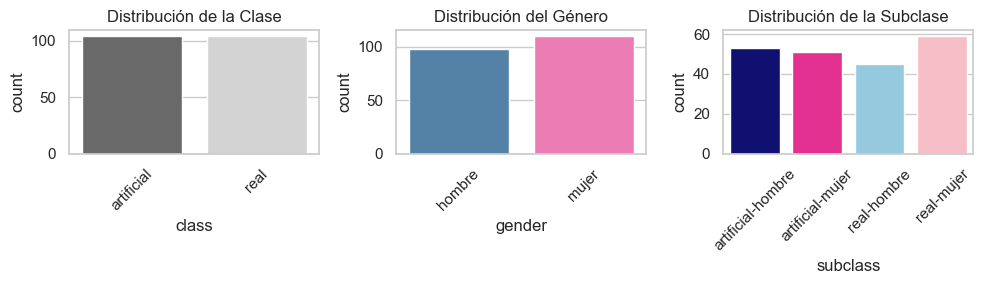

In [17]:
load_and_show_distribution(csv_file_path)

### Partición de los datos

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

In [19]:
def split_dataframe(df, target_column):
    # Verificar que la columna objetivo sea válida
    if target_column not in ['class', 'gender', 'subclass']:
        raise ValueError("target_column debe ser 'class', 'gender' o 'subclass'")
    
    # Seleccionar las primeras 13 columnas para X
    X = df.iloc[:, :13]
    
    # Seleccionar la columna objetivo para y
    y = df[target_column]
    
    return X, y

In [20]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

## Clasificación de Audios con coeficientes promedio MFCC

In [21]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [22]:
def NB_classifier(X, y):
    clf_nb = GaussianNB()
    scores = []
    y_all_pred = []
    y_all_test = []

    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf_nb.fit(X_train, y_train)
        y_pred = clf_nb.predict(X_test)

        y_all_pred = np.append(y_all_pred, y_pred)
        y_all_test = np.append(y_all_test, y_test)
        scores.append(f1_score(y_test, y_pred, average='weighted'))

    print("F1-score GNB: " + f"{np.mean(scores):.2f}" + " (" + f"{np.std(scores):.2f}" + ")")
    
    return y_all_pred, y_all_test, clf_nb

In [23]:
def plot_confusion_matrix(cm, clf):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = clf.classes_)
    disp.plot()
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(4)
    fig.set_figheight(4)
    plt.tick_params(axis='x', rotation=45)
    plt.show()

### Por género

(208, 13)
(208,)
F1-score GNB: 0.68 (0.10)


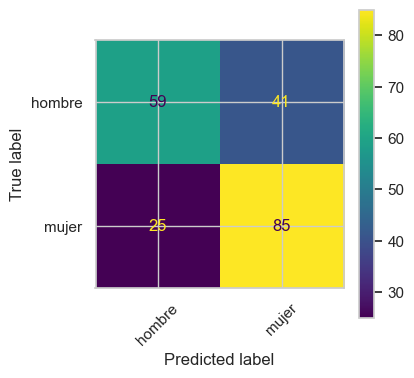

In [24]:
X, y = split_dataframe(df, 'gender')
print(X.shape)
print(y.shape)

predicted, actual, clf = NB_classifier(X, y)
cm = confusion_matrix(actual, predicted, labels=clf.classes_)
plot_confusion_matrix(cm, clf)

### Por clase

(208, 13)
(208,)
F1-score GNB: 0.91 (0.06)


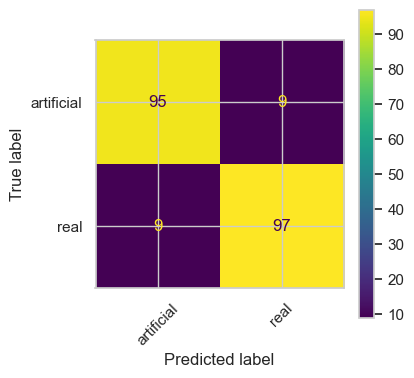

In [25]:
X, y = split_dataframe(df, 'class')
print(X.shape)
print(y.shape)

predicted, actual, clf = NB_classifier(X, y)
cm = confusion_matrix(actual, predicted, labels=clf.classes_)
plot_confusion_matrix(cm, clf)

### Por subclase

(208, 13)
(208,)
F1-score GNB: 0.58 (0.12)


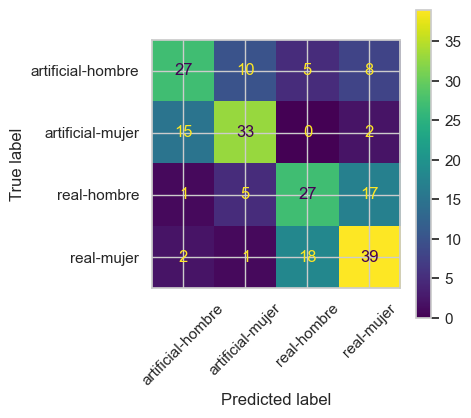

In [26]:
X, y = split_dataframe(df, 'subclass')
print(X.shape)
print(y.shape)

predicted, actual, clf = NB_classifier(X, y)
cm = confusion_matrix(actual, predicted, labels=clf.classes_)
plot_confusion_matrix(cm, clf)

## Clasificación de Audios con imágenes MFCC

In [27]:
import os
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

2024-02-04 19:03:47.348688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
def print_some_images(data):
    for _ in range(3):
        img, label = data.next()
        print(img.shape)
        plt.figure(figsize=(3, 3))
        plt.imshow(img[0])
        plt.show()

In [29]:
def prepare_data_splits(audio_mfcc_folder, output_folder):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba.
    
    Parámetros:
    - audio_mfcc_folder: Carpeta con subcarpetas que contienen las imágenes.
    - output_folder: Carpeta donde se guardarán las subcarpetas 'train', 'val' y 'test'.
    """
    # Asegurar que la carpeta de salida existe
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    
    for category in os.listdir(audio_mfcc_folder):
        category_dir = os.path.join(audio_mfcc_folder, category)
        if os.path.isdir(category_dir):
            # Crear las subcarpetas en la carpeta de salida
            for split in ['train', 'val', 'test']:
                split_dir = os.path.join(output_folder, split, category)
                os.makedirs(split_dir, exist_ok=True)
                
            # Obtener todas las imágenes en la categoría actual
            images = [os.path.join(category_dir, img) for img in os.listdir(category_dir)]
            
            # Dividir los datos: 70% entrenamiento, 20% validación, 10% prueba
            train_val_imgs, test_imgs = train_test_split(images, test_size=0.1, random_state=42)
            train_imgs, val_imgs = train_test_split(train_val_imgs, test_size=0.22, random_state=42)  # 0.22 de 0.9 es aproximadamente 0.2 del total
            
            # Función para copiar imágenes a las carpetas correspondientes
            def copy_images(images, dest_folder):
                for img_path in images:
                    shutil.copy(img_path, dest_folder)
            
            # Copiar imágenes a las carpetas correspondientes
            copy_images(train_imgs, os.path.join(output_folder, 'train', category))
            copy_images(val_imgs, os.path.join(output_folder, 'val', category))
            copy_images(test_imgs, os.path.join(output_folder, 'test', category))

# Ejemplo de uso
audio_mfcc_folder = 'Audio/MFCC'  # Ajustar a la ruta correcta de tus datos MFCC
output_folder = 'Audio/outputMFCC'  # Ajustar a donde quieras guardar las particiones
prepare_data_splits(audio_mfcc_folder, output_folder)

In [30]:
def clasificar_imagenes_mfcc(audio_mfcc_folder):
    # Inicializamos los generadores de datos
    datagen_train = ImageDataGenerator(rescale=1./255)
    datagen_val = ImageDataGenerator(rescale=1./255)
    datagen_test = ImageDataGenerator(rescale=1./255)
    
    # Dimensiones de las imágenes MFCC
    height = 40
    width = 100    
    
    train_generator = datagen_train.flow_from_directory(
        os.path.join(audio_mfcc_folder, 'train'),
        target_size=(height, width),
        batch_size=32,
        class_mode='categorical'
    )
    
    print_some_images(train_generator)

    validation_generator = datagen_val.flow_from_directory(
        os.path.join(audio_mfcc_folder, 'val'),
        target_size=(height, width),
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = datagen_test.flow_from_directory(
        os.path.join(audio_mfcc_folder, 'test'),
        target_size=(height, width),
        batch_size=32,
        class_mode='categorical',
        shuffle=False  # Importante para la evaluación: no barajar los datos de prueba
    )

    # Construir el modelo de CNN
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dense(128, activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])

    # Compilar el modelo
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Configuración de Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

    # Entrenar el modelo
    model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        #callbacks=[early_stopping],       
        epochs=10  # Cambiar según sea necesario
    )
    
    # Después del entrenamiento, evaluamos el modelo en el conjunto de prueba
    print("Evaluando el modelo en el conjunto de prueba...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    test_loss_format = "{:.2f}".format(test_loss)
    test_accuracy_format = "{:.2f}".format(test_accuracy)

    print(f"Test Loss: {test_loss_format}")
    print(f"Test Accuracy: {test_accuracy_format}")
    
    # Predicciones en el conjunto de prueba para la matriz de confusión
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Matriz de confusión
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_labels)
    disp.plot()
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(4)
    fig.set_figheight(4)
    plt.tick_params(axis='x', rotation=45)
    plt.show()    

    return model

Found 143 images belonging to 4 classes.
(32, 40, 100, 3)


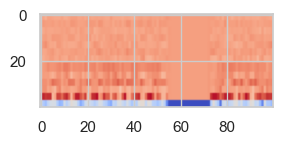

(32, 40, 100, 3)


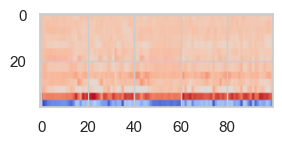

(32, 40, 100, 3)


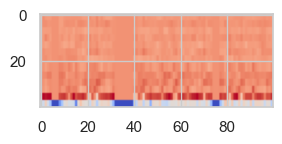

Found 42 images belonging to 4 classes.
Found 23 images belonging to 4 classes.
Epoch 1/10
4/4 [==============================] - 3s 520ms/step - loss: 1.4650 - accuracy: 0.2432 - val_loss: 1.4288 - val_accuracy: 0.2188
Epoch 2/10
4/4 [==============================] - 2s 414ms/step - loss: 1.3974 - accuracy: 0.2500 - val_loss: 1.3854 - val_accuracy: 0.2188
Epoch 3/10
4/4 [==============================] - 1s 421ms/step - loss: 1.3999 - accuracy: 0.1982 - val_loss: 1.3760 - val_accuracy: 0.3125
Epoch 4/10
4/4 [==============================] - 1s 383ms/step - loss: 1.3849 - accuracy: 0.2252 - val_loss: 1.3828 - val_accuracy: 0.3125
Epoch 5/10
4/4 [==============================] - 1s 378ms/step - loss: 1.3863 - accuracy: 0.2252 - val_loss: 1.3829 - val_accuracy: 0.3125
Epoch 6/10
4/4 [==============================] - 1s 370ms/step - loss: 1.3793 - accuracy: 0.2523 - val_loss: 1.3825 - val_accuracy: 0.2188
Epoch 7/10
4/4 [==============================] - 1s 358ms/step - loss: 1.3792 -

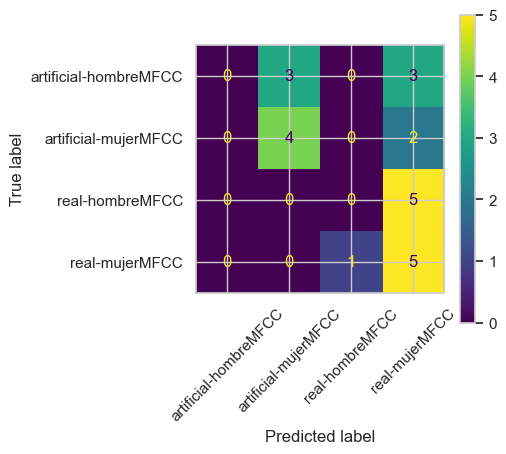

In [31]:
audio_mfcc_folder = 'Audio/outputMFCC'  # Ajustar a la ruta correcta
clasificar_imagenes_mfcc(audio_mfcc_folder)

### Algunas reflexiones

Usar los coeficientes MFCC para entrenar un modelo de aprendizaje básico (Naive Bayes), funciona bien.
Usar las imágenes MFCC para entrenar un modelo de aprendizaje profundo (CNN), no funcionó con una arquitectura genérica, faltan más datos?